# Segmentaion project
AIFFEL 대전 탐색 노드 10   
이미지에서 배경을 blur해보는 프로젝트이다.
  
프로세스는 다음과 같다.     
1. Import package 
2. Data loading
3. Model loading
4. Image processing
5. Analysis

## 1. Import package

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

## 2. Data loading
인물 사진, 고양이 사진, 크로마키를 할 배경 사진을 불러온다.

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpg'   
img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/bg.jpg'   

img_orig = cv2.imread(img_path) 
cat_orig = cv2.imread(img_path2)
bg_orig = cv2.imread(img_path3)
print(img_orig.shape)
print(bg_orig.shape)

(3557, 5335, 3)
(2638, 3778, 3)


크로마키를 하기 위해서 이미지의 크기를 맞춰준다.

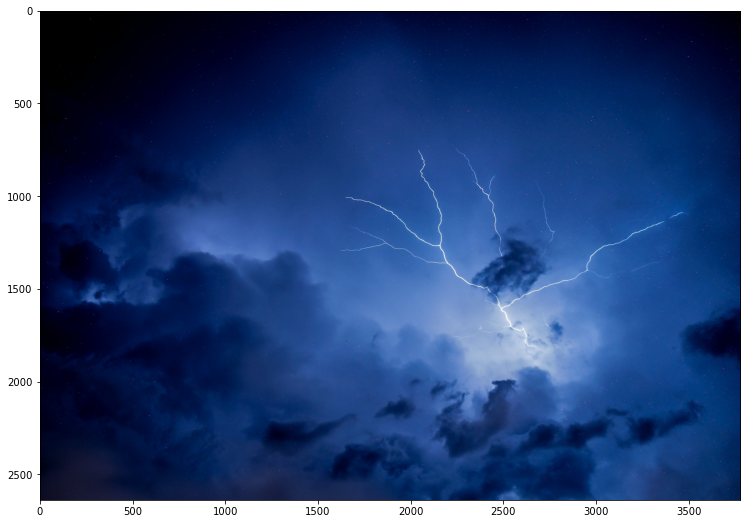

In [3]:
plt.figure(figsize=(15, 9))
plt.imshow(cv2.cvtColor(bg_orig, cv2.COLOR_BGR2RGB))
plt.show()

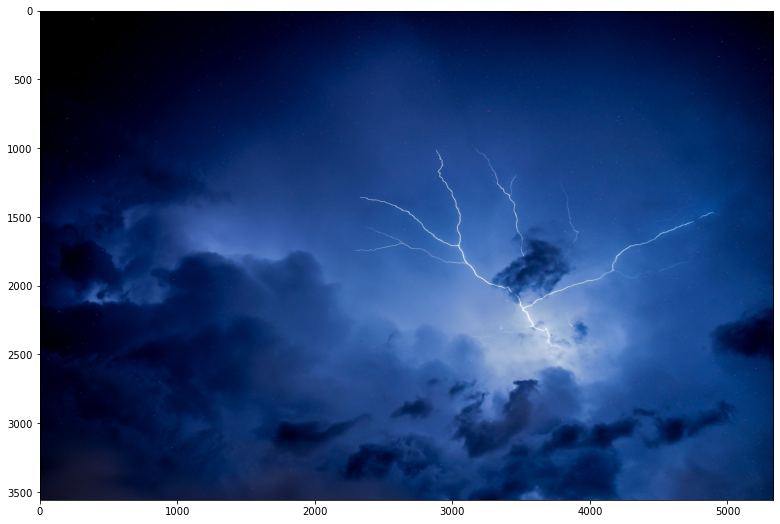

In [4]:
bg_orig = cv2.resize(bg_orig, dsize=(5335,3557), interpolation=cv2.INTER_AREA)
plt.figure(figsize=(15, 9))
plt.imshow(cv2.cvtColor(bg_orig, cv2.COLOR_BGR2RGB))
plt.show()

## 3. Model loading
미리 정의되고 훈련되어 있는 모델을 가져온다.

In [5]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [6]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel-dj28/aiffel/human_segmentation/models
model loaded successfully!


## 4. Image processing
모델을 이용하여 이미지를 segmentation을 한다.

In [7]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

cat_resized, cat_seg_map = MODEL.run(cat_orig)
print (cat_orig.shape, cat_resized.shape, cat_seg_map.max())

(3557, 5335, 3) (342, 513, 3) 15
(5275, 3517, 3) (513, 342, 3) 8


모델에서 제공하는 label들이다.

In [8]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

모델을 이용하여 세그멘테이션이 잘 되어 있는 지 확인한다.

<Figure size 1080x648 with 0 Axes>

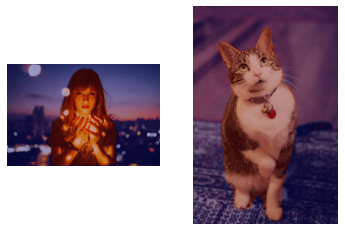

In [9]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

cat_show = cat_resized.copy()
cat_seg_map = np.where(cat_seg_map == 8, 8, 0) # 예측 중 고양이만 추출
cat_mask = cat_seg_map * (255/cat_seg_map.max()) # 255 normalization
cat_mask = cat_mask.astype(np.uint8)
cat_color_mask = cv2.applyColorMap(cat_mask, cv2.COLORMAP_JET)
cat_show = cv2.addWeighted(cat_show, 0.6, cat_color_mask, 0.35, 0.0)


plt.figure(figsize=(15, 9))
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
ax1.axis("off")

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(cv2.cvtColor(cat_show, cv2.COLOR_BGR2RGB))
ax2.axis("off")

plt.show()

배경 부분과 피사체 부분 분리하여 시각화

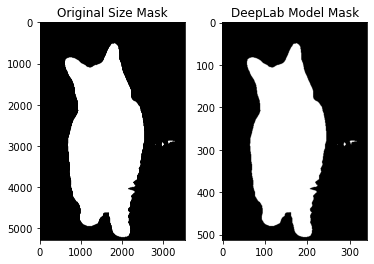

In [10]:
cat_mask_up = cv2.resize(cat_mask, cat_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, cat_mask_up = cv2.threshold(cat_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(cat_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(cat_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

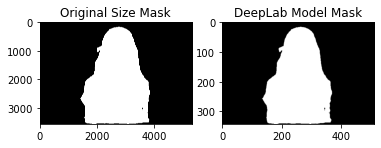

In [11]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

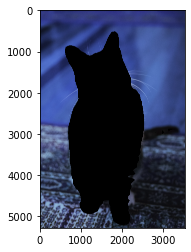

In [12]:
cat_mask_color = cv2.cvtColor(cat_mask_up, cv2.COLOR_GRAY2BGR)
cat_bg_mask = cv2.bitwise_not(cat_mask_color)
cat_bg = cv2.bitwise_and(cat_orig, cat_bg_mask)
plt.imshow(cat_bg)
plt.show()

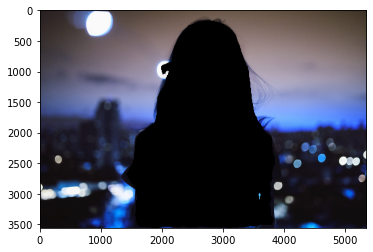

In [13]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

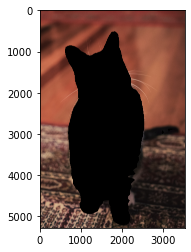

In [14]:
cat_bg_blur = cv2.blur(cat_bg, (13,13))
plt.imshow(cv2.cvtColor(cat_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

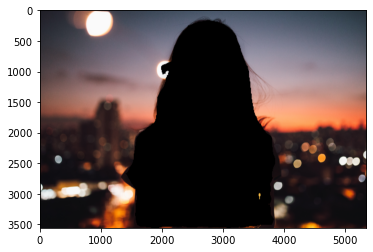

In [15]:
img_bg_blur2 = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur2, cv2.COLOR_BGR2RGB))
plt.show()

이미지 자체에 blur가 되어 있어서 구분하기 위하여 더 심하게 blur 처리를 한다.

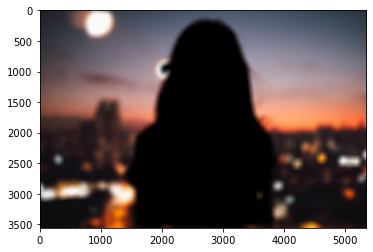

In [16]:
img_bg_blur = cv2.blur(img_bg, (100,100))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

blur한 배경과 피사체 부분을 결합하여 결과를 보여준다.(인물모드 사진)   
크로마키도 적용을 해본다.

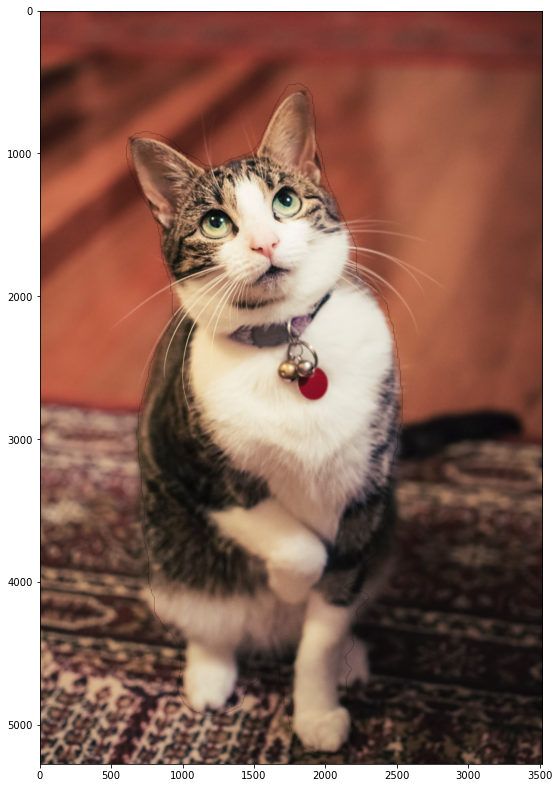

In [17]:
plt.figure(figsize=(9, 15))
cat_concat = np.where(cat_mask_color==255, cat_orig, cat_bg_blur)
plt.imshow(cv2.cvtColor(cat_concat, cv2.COLOR_BGR2RGB))
plt.show()

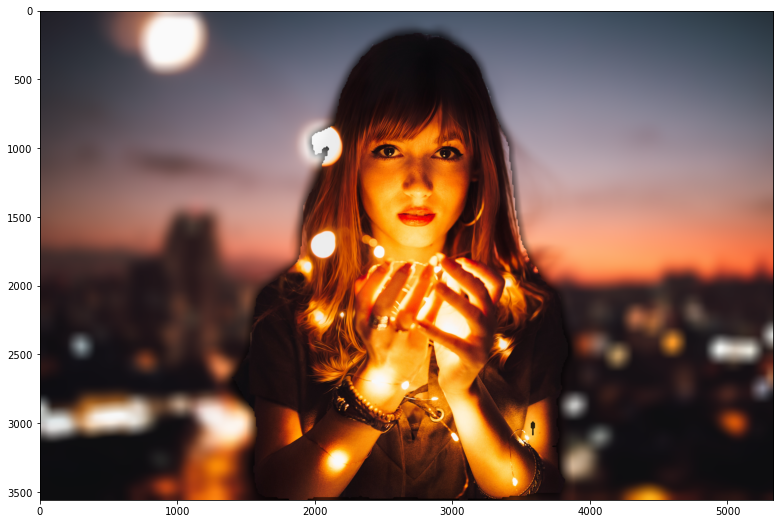

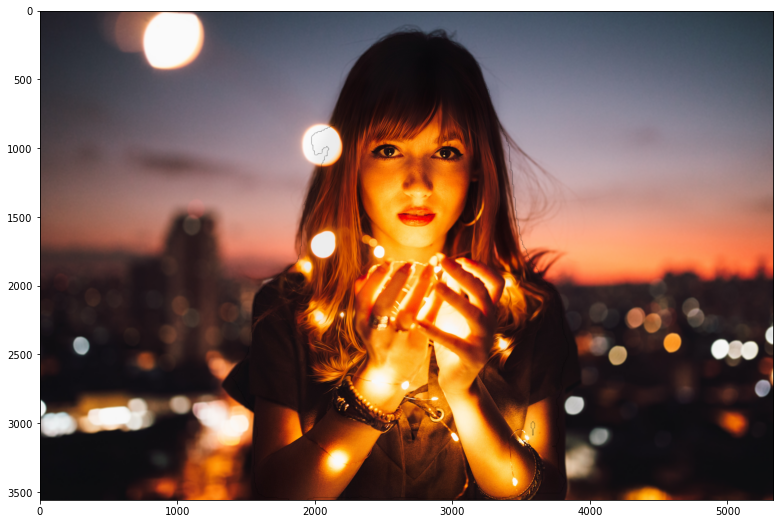

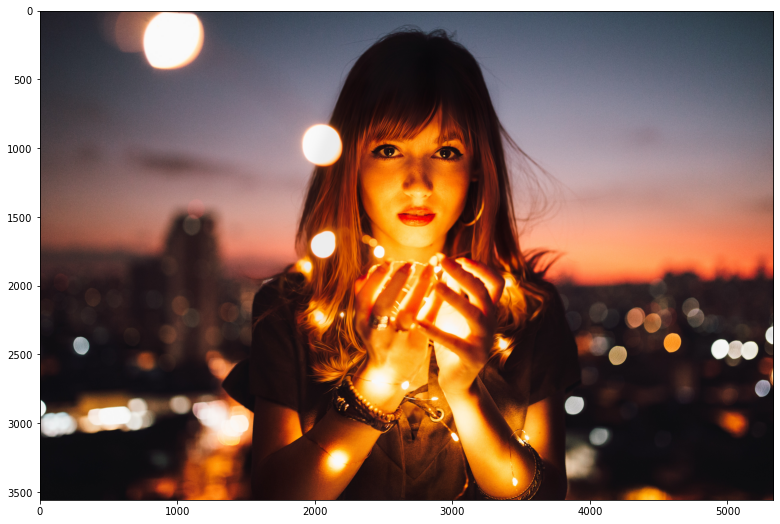

In [25]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
img_concat2 = np.where(img_mask_color==255, img_orig, img_bg_blur2)

plt.figure(figsize=(15, 9))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

plt.figure(figsize=(15, 9))
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
plt.show()

plt.figure(figsize=(15, 9))
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

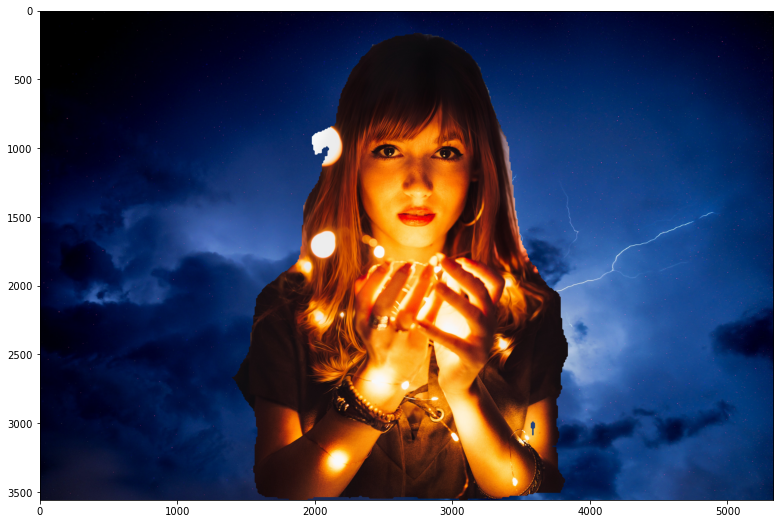

In [19]:
plt.figure(figsize=(15, 9))
img_concat = np.where(img_mask_color==255, img_orig, bg_orig)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 5. Analysis

마지막에 인물모드 사진으로 고양이와 사람 그리고 배경전환 크로마키사진을 제작하였다.   
우선 사용한 이미지 자체가 배경이 이미 blur한 상태이기 때문에   
blur처리를 하여도 크게 변경되는 것을 볼 수 없어서 심하게 blur 처리를 한 것과 비교를 하였다.   
그래서 2번째 3개의 이미지를 보면 첫 번째는 (100,100)으로 심하게 blur 처리를 한 것이고   
두 번째는 (13,13)으로 blur 처리를 한 것이고, 마지막은 원본이다.
비교해보면 두 번째와 마지막은 큰 차이가 없어서 첫 번째 이미지를 만들었다.   
   
문제를 찾아보면 머리카락 옆에 빛이 같이 세그멘테이션 되어 있고, 왼쪽 팔의 중간이 뚫려 있다.
크로마키 사진을 보면 인물의 세그멘테이션이 어떻게 되어 있는지 더 명확히 알 수 있다.
고양이 사진의 경우에는 꼬리 부분이 세그멘테이션이 되어 있지 않다.

### 해결 방법
사진에 아웃포커싱 효과를 내는 것은 결국, 렌즈와의 거리를 이용하여 가까운 대상에만 초점을 맞추는 것이다. 여러 가지 기술들을 이용하면 렌즈로 부터 대상까지의 거리를 계산할 수 있다. 그런 기술을 가진 카메라를 3d depth camera라고 한다. 방식은 대표적으로 3가지 방식이 있고, 각각 스테레오, ToF, structured pattern 방식이다. 아니면 Struct2Depth 같은 딥러닝 기술을 이용하여 depth을 계산할 수도 있다.   
계산한 depth을 이용하여 초점을 맞출 대상의 거리를 초과하는 것을 모두 제외하는 segmentation으로 배경을 모두 제거할 수 있다. 이 방법으로 고양이 꼬리도 포함할 수 있도록 하여 문제를 해결할 수 있다. 그리고 위에서 문제가 된 빛까지 segmentation한 것과 팔의 중간 부분이 뚫리는 것의 경우에는 segmentation하는 딥러닝 모델의 성능을 높여서 해결할 수 있을 것이다.

## 회고 및 루브릭 평가

### 루브릭 평가 항목
1.  인물모드 사진을 성공적으로 제작하였다.(아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.)
2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.(인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.)
3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.(추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.)

### 평가 항목에 대한 수행
1. 마지막에서 각각 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 제작하였다.
2. 제작한 인물모드 사진들에서 나타나는 문제점을 '5. analysis'에서 문제점들에 대해서 지적하였다.
3. 마지막에 해결방법으로 depth 정보를 활용하여 오류를 보완할 수 있도록 하는 방법에 대해서 간략하게 제시하였다.

### 회고

노션에 공지된 꼭 포함이 되어야 할 점
- 이번 프로젝트에서 **어려웠던 점,**
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
- **자기 다짐**

---
- **어려웠던 점**    
가장 어려웠던 점은 데이터를 수집하는 것이였다. 데이터를 찾기 위해서 무료로 사진을 얻을 수 있는 곳에서 고심한 끝에 고를 수 있었다.
---
- **알아낸 점**    
노드를 하면서 사진을 찍는 원리에 대해서 알 수 있었다. 그리고 아웃포커싱의 개념과 사진을 찍을 때 어떻게 해야 할 지 배울 수 있었다.

- **모호한 점**    
모델을 직접 구현한 것이 아닌 미리 정의되어 있고 훈련되어 있는 것을 사용하다보니 내부 구조에 대해서 정확히 어떻게 되어 있는 지에 대해서 모른다.
---
- **시도한 것들**   
인물 사진과 고양이 사진으로 segmentation을 하였고, 배경도 resize에서 추가하였다.

---
- **우브릭 평가 관련 지표**   
제 예상에는 모두 달성되었다고 생각한다. 그 이유는 위에 있는 **평가 항목에 대한 수행**에 나와있다.  
- **자기 다짐** 및 **나의 생각들**      
기존의 노드보다 쉽게 끝낼 수 있었다. 역시 직접 모델을 구현하지 않고 훈련도 하지 않으니까 빠르게 마칠 수 있는 것 같다. 이번 주제는 segmenation이기 때문에 인공지능과 연관시키려면 결국, segmentation하는 부분을 공부를 해야 하는데 노드에서는 아쉽게도 구체적으로 설명을 해주는 부분이 없어서 좀 더 찾아봐야 할 것 같다.